In [35]:
'''
Beginning implementation of "Motion without movement" illusions
'''

import cv2
from PIL import Image
import matplotlib.pylab as plt
import os
import numpy as np 
import imageio
from skimage.exposure import rescale_intensity



(-0.5, 299.5, 326.5, -0.5)

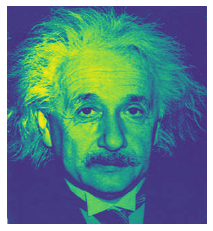

In [42]:
# load in image to be transformed  

img_pth = "./einstein.jpeg"

img = cv2.imread(img_pth)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # ensure unicolor scale for now 

plt.imshow(img)
plt.axis('off')

In [43]:
kernel = np.array((
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]), dtype="int")

In [50]:

def convolve2D(image, kernel, padding=0, strides=1):
    
    # code from: https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
    
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break
    # normalize output scale: https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/ 
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    return output

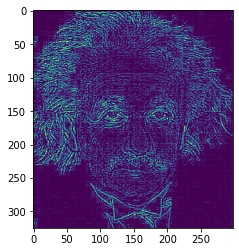

In [51]:
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

sharpen = np.array((
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]), dtype="int")

conv_img = convolve2D(img, kernel)

plt.imshow(conv_img)